In [10]:
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import os
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob

# preparing data:

In [11]:
training_dir = "C:\\Users\\Lama\\Desktop\\conformal_prediction\\archive (4)\\seg_train\\seg_train"
test_dir = "C:\\Users\\Lama\\Desktop\\conformal_prediction\\archive (4)\\seg_test\\seg_test"

In [12]:
image = cv2.imread('C:\\Users\\Lama\\Desktop\\conformal_prediction\\archive (4)\\seg_train\\seg_train\\sea\\10053.jpg')
height, width, channels = image.shape
print(f"Image shape: (height={height}, width={width}, channels={channels})")

Image shape: (height=150, width=150, channels=3)


In [13]:
Total_TrainImages = glob.glob(os.path.join(training_dir, '*/*.jpg'))
print("Total number of training images: ", len(Total_TrainImages))

train_df = pd.DataFrame()
train_df['Filename'] = [os.path.basename(path) for path in Total_TrainImages]
train_df['ClassId'] = [os.path.basename(os.path.dirname(path)) for path in Total_TrainImages]

print(train_df.head(5))


Total number of training images:  14034
    Filename    ClassId
0      0.jpg  buildings
1  10006.jpg  buildings
2   1001.jpg  buildings
3  10014.jpg  buildings
4  10018.jpg  buildings


In [14]:
Total_TestImages = glob.glob(os.path.join(test_dir, '*/*.jpg'))
print("Total number of test images: ", len(Total_TestImages))

Total number of test images:  3000


In [ ]:
n_epochs = 1 
batch_size = 32
learning_rate = 0.001

In [15]:
# Transformations sur les images (le modele ResNet utilise des images de taille 224x224)
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(training_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# DataLoaders
batch_size = batch_size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [16]:
calib_test = enumerate(test_loader)
batch_idx, (calib_data, calib_targets) = next(calib_test)
batch_idx, (test_data, test_targets) = next(calib_test)

# modele ResNet18:

In [17]:
model = models.resnet18(pretrained=True)

# Geler les paramètres (poids) du modèle
for param in model.parameters():
    param.requires_grad = False

# Adapter la dernière couche FC
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)  

device = "cpu"
model = model.to(device)

C:\Users\Lama\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lama\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

def train(epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")



In [19]:
n_epochs = n_epochs

for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/14034 (0%)]	Loss: 2.018703
Train Epoch: 1 [3200/14034 (23%)]	Loss: 0.441220
Train Epoch: 1 [6400/14034 (46%)]	Loss: 0.306337
Train Epoch: 1 [9600/14034 (68%)]	Loss: 0.425510
Train Epoch: 1 [12800/14034 (91%)]	Loss: 0.476770

Test set: Average loss: 0.0095, Accuracy: 2677/3000 (89%)



# conformal prediction:

In [61]:
def score(data,truth):
    s = 0
    probs=F.softmax(model(data)[0], dim=0).detach().numpy()    #les labels
    labels = np.arange(10)
    idx = np.argsort(probs)[::-1]
    i=0
    test = -1
    while int(truth) != int(test):
        s += probs[idx[i]]
        test = labels[idx[i]]
        i += 1
    return s

In [62]:
def calibration(calib_data,calib_targets,alpha):
    S = np.empty(calib_data.shape[0])
    for i in np.arange(calib_data.shape[0]):
        S[i] = score(calib_data[i:i+1],calib_targets[i])
    return np.quantile(S,1-alpha)

In [63]:
q_hat = calibration(calib_data,calib_targets,alpha = 0.1)

In [64]:
q_hat

0.9906229346990585

In [67]:
def ens_pred(x, q_hat):
    probs=F.softmax(model(x)[0], dim=0).detach().numpy()
    labels = np.arange(len(probs))
    idx = np.argsort(probs)[::-1]
    p = 0
    i = 0
    ens = {}

    while p < q_hat:
        ens[labels[idx[i]]] = probs[idx[i]]
        p += probs[idx[i]]
        i += 1

    return ens

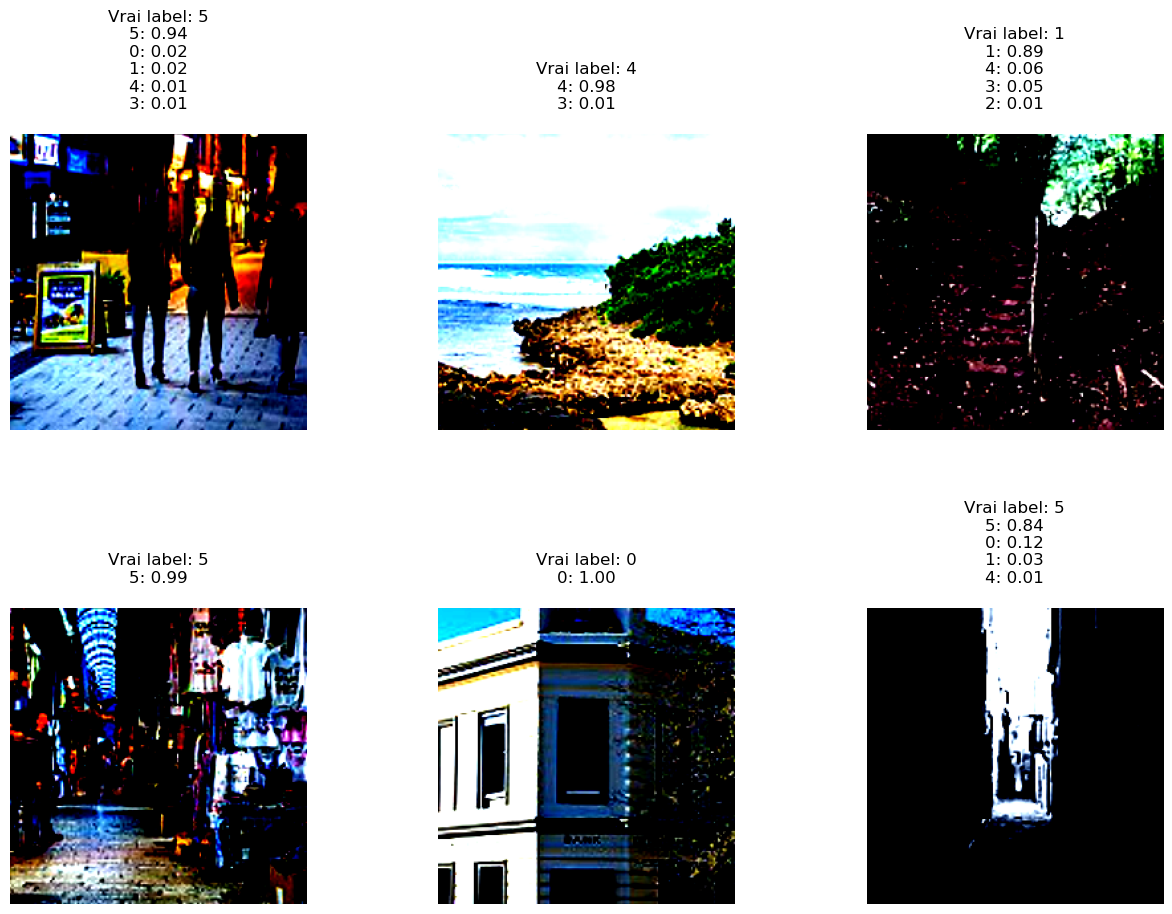

In [68]:
def get_random_images(loader, num_images=6):
    images = []
    targets = []
    while len(images) < num_images:
        for data, target in loader:
            for i in range(data.size(0)):
                if len(images) < num_images:
                    images.append(data[i])
                    targets.append(target[i])
                else:
                    break
            if len(images) >= num_images:
                break
    return images, targets




random_images, random_targets = get_random_images(test_loader, 6)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.subplots_adjust(wspace=0.4, hspace=0.6)

for i, ax in enumerate(axs.flatten()):
    img = random_images[i]
    label = random_targets[i]
    img_np = img.numpy().transpose((1, 2, 0))
    img_np = np.clip(img_np, 0, 1)
    ax.imshow(img_np)

    img_tensor = img.to(device)
    img_tensor = img_tensor.unsqueeze(0)
    
    ens = ens_pred(img_tensor, q_hat)  
    pred_title = "".join([f"{key}: {ens[key]:.2f}\n" for key in ens.keys()])
    ax.set_title(f"Vrai label: {label}\n{pred_title}")  
    ax.axis('off')

plt.show()